#**Section C Team 36 Project**

##**About the dataset**

The Kaggle dataset is a preprocessed 2D image version of the original OASIS-1 brain MRI dataset. It’s built from the Open Access Series of Imaging Studies (OASIS) – a well-known public MRI dataset of young, middle-aged, and older adults, both non-demented and demented.The Kaggle version converts the original 3D MRI volumes into many 2D axial slices for deep learning.

The dementia labels come from the Clinical Dementia Rating (CDR) scale and are grouped into 4 categories:

*   Non-demented
*   Very mild dementia
*   Mild dementia
*   Moderate dementia

About 80,000 MRI slices in total from around 461 patients. Slices are taken from the middle portion of the brain volume (e.g. slice indices 100–160) to focus on informative regions They organized them into 4 class folders (one per condition) when preparing for training.

So, it’s a big set of 2D brain slices, not raw 3D medical volumes.

In [ ]:
# Import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import os
from torch.utils.data import DataLoader, WeightedRandomSampler
import shutil



In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Downloading files using Kaggle json API

In [ ]:
from google.colab import files

# Select kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Create the .kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

kaggle.json is now at: ['kaggle.json']


In [ ]:
!pip install -q kaggle

In [ ]:
# Make a folder to store the data
!mkdir -p data
!kaggle datasets download -d ninadaithal/imagesoasis -p data --unzip

Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
 93% 1.14G/1.23G [00:01<00:00, 851MB/s]
100% 1.23G/1.23G [00:01<00:00, 1.10GB/s]


In [ ]:
print("Contents of ./data:")
print(os.listdir("data"))

Contents of ./data:
['Data']


#**Viewing raw images**

Let's view what our images look like raw so we can decide on how to transform and normalize them.

Num files in sample_dir: 67222
First few files: ['OAS1_0277_MR1_mpr-2_147.jpg', 'OAS1_0001_MR1_mpr-4_118.jpg', 'OAS1_0249_MR2_mpr-3_115.jpg', 'OAS1_0058_MR1_mpr-2_152.jpg', 'OAS1_0121_MR1_mpr-1_127.jpg']
PIL mode: RGB
Array shape: (248, 496, 3)
Pixel min/max: 0 253


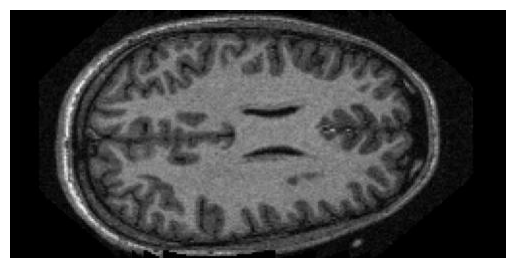

In [ ]:

sample_dir = "data/Data/Non Demented"   # pick any class folder
sample_files = os.listdir(sample_dir)
print("Num files in sample_dir:", len(sample_files))
print("First few files:", sample_files[:5])

# Open one image
img_path = os.path.join(sample_dir, sample_files[0])
img = Image.open(img_path)
arr = np.array(img)

print("PIL mode:", img.mode)          # 'L' = grayscale, 'RGB' = color
print("Array shape:", arr.shape)      # (H, W) or (H, W, C)
print("Pixel min/max:", arr.min(), arr.max())

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

#Grabbing labels, train-test split and transformation

1. **Load all data:** Use `ImageFolder` to load every MRI slice and its dementia label into one big dataset.
2. **Group by patient:** Use the filename to extract a `patient_id` and group all slices that belong to the same patient.
3. **Patient-wise split (64/16/20):** For each class, split patients (not slices) into train, validation, and test to avoid leakage and keep class balance.
4. **Define transforms:** Set up preprocessing + light augmentation for the training set, and clean (no-augmentation) transforms for validation and test.
5. **Build subset datasets:** Create train/val/test datasets by selecting only the slice indices that belong to patients in each split and applying the right transforms.
6. **Create dataloaders:** Wrap each dataset in a DataLoader so the model can iterate over mini-batches during training, validation, and testing.

##Part 1 – Build the base dataset (all slices)

We use ImageFolder on data/MRI_IMAGES, which has 4 folders:
Mild Dementia, Moderate Dementia, Non Demented, Very mild Dementia.

ImageFolder:

* Treats each folder name as a class label.

* Assigns them integer IDs, e.g. Mild Dementia → 0, Moderate Dementia → 1, Non Demented → 2, Very mild Dementia → 3

It builds one big dataset called base_dataset:

* Conceptually:
[ (slice_0_path, label_0), (slice_1_path, label_1), ..., (slice_N_path, label_N) ]

* Each element = one MRI slice and its class label.

We print:

* the class names (base_dataset.classes)

* the mapping folder → label ID (class_to_idx)

* the total number of slices (len(base_dataset))

* one example sample to confirm the filename format.

**Goal of Part 1:**
Create a single object that contains all slices + labels, so we can then organize them by patient.

In [ ]:
import random
from collections import defaultdict

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

data_dir = "data/Data"   # root with 4 class folders

# No transform yet – we want raw PIL images & file paths
base_dataset = datasets.ImageFolder(root=data_dir, transform=None)

print("Classes:", base_dataset.classes)
print("class_to_idx:", base_dataset.class_to_idx)
print("Total slices:", len(base_dataset))

print("Example sample:", base_dataset.samples[0])

Classes: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']
class_to_idx: {'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}
Total slices: 86437
Example sample: ('data/Data/Mild Dementia/OAS1_0028_MR1_mpr-1_100.jpg', 0)


##Part 2 – Group slices by patient

Why?
Each patient has ~60 slices. If we randomly split at the slice level, slices from the same patient could end up in both train and test → data leakage and over-optimistic accuracy.

So in Part 2 we:

* Loop over every (filepath, label) in base_dataset.samples. Example filename:
OAS1_0028_MR1_mpr-1_100.jpg

* For each file: Take just the filename: OAS1_0028_MR1_mpr-1_100.jpg.
* Split by underscores: ['OAS1', '0028', 'MR1', 'mpr-1', '100.jpg']

* Define the patient ID as the first 3 parts joined: patient_id = "OAS1_0028_MR1". All slices whose name starts with OAS1_0028_MR1_... belong to the same patient.

We build three data structures:

* patient_to_indices[patient_id] → list of slice indices for that patient

* e.g. patient_to_indices['OAS1_0028_MR1'] = [0, 1, 2, ..., 59]

* patient_label[patient_id] → class label (0–3) for that patient

We also check that all slices for a patient have the same label; if not, we raise an error.

* class_to_patients[label] → set of patient IDs that belong to each class
* e.g. class_to_patients[0] = all Mild Dementia patient IDs.

We then print:

* Total number of unique patients.

* For each label: number of patients in that class.

**Goal of Part 2:**
Stop thinking of the dataset as “independent slices” and instead as patients with groups of slices, so we can do a subject-level train/val/test split.

In [ ]:
# Group by patient
patient_to_indices = defaultdict(list)   # patient_id -> list of slice indices
patient_label      = dict()             # patient_id -> class label (0..3)
class_to_patients  = defaultdict(set)   # label -> set of patient_ids

for idx, (filepath, label) in enumerate(base_dataset.samples):
    fname = os.path.basename(filepath)
    parts = fname.split('_')

    if len(parts) < 3:
        raise ValueError(f"Unexpected filename format: {fname}")

    # Patient/session ID is the first 3 chunks: 'OAS1_0028_MR1'
    patient_id = "_".join(parts[:3])
    patient_to_indices[patient_id].append(idx)

    # Check that all slices of this patient have the same class label
    if patient_id in patient_label and patient_label[patient_id] != label:
        raise ValueError(f"Patient {patient_id} has inconsistent labels "
                         f"{patient_label[patient_id]} vs {label}")
    patient_label[patient_id] = label
    class_to_patients[label].add(patient_id)

print("Total unique patients:", len(patient_to_indices))
for lbl, pats in class_to_patients.items():
    print(f"Label {lbl} ({base_dataset.classes[lbl]}): {len(pats)} patients")

Total unique patients: 366
Label 0 (Mild Dementia): 21 patients
Label 1 (Moderate Dementia): 2 patients
Label 2 (Non Demented): 285 patients
Label 3 (Very mild Dementia): 58 patients


##Part 3 – Patient-level 64/16/20 stratified split

We split by patient, not by slice, to avoid data leakage (no patient appears in more than one split).

For each class:

* Take the list of patient IDs in that class (class_to_patients[label]), shuffle it,

* Assign ~20% of patients to test, ~16% to validation, and ~64% to train.

* We collect these into global lists: train_patients, val_patients, test_patients.

* Then we convert patient IDs → slice indices using patient_to_indices, giving: train_indices, val_indices, test_indices.

* These index lists are what we’ll use to build the final train/val/test datasets and dataloaders.

In [ ]:
# Stratifying by patients
random.seed(42)

train_patients = []
val_patients   = []
test_patients  = []

for lbl, patients in class_to_patients.items():
    patients = list(patients)
    random.shuffle(patients)

    n = len(patients)
    n_test = int(0.20 * n)       # 20% test
    n_dev  = n - n_test          # remaining 80% -> train+val
    n_val  = int(0.20 * n_dev)   # 20% of dev = 16% overall
    # rest (~64%) = train

    cls_test  = patients[:n_test]
    cls_val   = patients[n_test:n_test + n_val]
    cls_train = patients[n_test + n_val:]

    train_patients.extend(cls_train)
    val_patients.extend(cls_val)
    test_patients.extend(cls_test)

    print(
        f"Class {lbl} ({base_dataset.classes[lbl]}): "
        f"{len(cls_train)} train patients, "
        f"{len(cls_val)} val patients, "
        f"{len(cls_test)} test patients"
    )

print("Total train patients:", len(train_patients))
print("Total val patients:",   len(val_patients))
print("Total test patients:",  len(test_patients))

# Turn a list of patient IDs into slice indices
def patients_to_indices(patient_list):
    idxs = []
    for pid in patient_list:
        idxs.extend(patient_to_indices[pid])
    return idxs

train_indices = patients_to_indices(train_patients)
val_indices   = patients_to_indices(val_patients)
test_indices  = patients_to_indices(test_patients)

print("Total train slices:", len(train_indices))
print("Total val slices:",   len(val_indices))
print("Total test slices:",  len(test_indices))


Class 0 (Mild Dementia): 14 train patients, 3 val patients, 4 test patients
Class 1 (Moderate Dementia): 2 train patients, 0 val patients, 0 test patients
Class 2 (Non Demented): 183 train patients, 45 val patients, 57 test patients
Class 3 (Very mild Dementia): 38 train patients, 9 val patients, 11 test patients
Total train patients: 237
Total val patients: 57
Total test patients: 72
Total train slices: 55998
Total val slices: 13237
Total test slices: 17202


##Part 4 – Data transforms (train vs. val/test)

We define image transforms to:

* Make all images the same size (224×224),

* Convert them to PyTorch tensors,

* Normalize pixel values for more stable training,

* And (for train only) add light data augmentation.

train_transform:

* Resize(224, 224) → standard input size for the model.

* RandomRotation(±10°) + fill=0 → small realistic head tilt, background stays black.

* RandomHorizontalFlip(p=0.5) → optional left–right flip to increase variability.

* ColorJitter → slight brightness/contrast changes to mimic scanner differences.

* ToTensor() → converts PIL image to tensor in [0, 1].

* Normalize(mean, std) → rescales values (here using [0.5, 0.5, 0.5] as a simple default).

val_test_transform:

* Only Resize, ToTensor, and Normalize (no randomness).

* Ensures validation and test results are consistent and comparable.

In [ ]:
# Transforms
norm_mean = [0.5, 0.5, 0.5]
norm_std  = [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(
        degrees=10,
        fill=0
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.1,
        contrast=0.1
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std),
])



##Part 5 – Wrapper dataset (MRISubset)

base_dataset contains all slices and labels; train_indices, val_indices, test_indices tell us which slice indices belong to each split.

We define a custom dataset MRISubset that:

Stores:
* the base_dataset,

* a list of indices (which slices to use),

* and a transform (how to preprocess each image).

* __len__ → returns how many slices are in this subset.

__getitem__(i):
* looks up the real index self.indices[i] inside base_dataset,

* gets (img, label) for that slice,

* applies the appropriate transform,

* returns (transformed_img, label).

We then create:

* train_dataset using train_indices + train_transform (with augmentation),

* val_dataset and test_dataset using their indices + val_test_transform (no augmentation).

The print at the end confirms how many slices are in each split.

In [ ]:
# Wrapper Dataset
class MRISubset(Dataset):
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, label = self.base_dataset[self.indices[i]]  # img is PIL
        if self.transform is not None:
            img = self.transform(img)
        return img, label

train_dataset = MRISubset(base_dataset, train_indices, train_transform)
val_dataset   = MRISubset(base_dataset, val_indices,   val_test_transform)
test_dataset  = MRISubset(base_dataset, test_indices,  val_test_transform)

print("Final sizes (slices) -> "
      f"train: {len(train_dataset)}, "
      f"val: {len(val_dataset)}, "
      f"test: {len(test_dataset)}")

Final sizes (slices) -> train: 55998, val: 13237, test: 17202


##Part 6 - Dataloading and Batching

In [ ]:
# Complete DataLoaders
# Parameters
batch_size = 32
num_workers = 2
pin_memory = True if torch.cuda.is_available() else False

# If train_dataset is defined and has attribute .targets or you used a df, we compute class weights.
def compute_sampler_from_dataset(ds):
    """Return a WeightedRandomSampler or None if not possible."""
    # try several ways to access labels
    labels = None
    if hasattr(ds, 'targets'):
        labels = ds.targets
    else:
        # try reading labels by iterating once (safe for small datasets)
        try:
            labels = [ds[i][1] for i in range(len(ds))]
        except Exception as e:
            print("Warning: couldn't read labels to build sampler:", e)
            labels = None

    if labels is None:
        return None

    labels = list(labels)
    classes, counts = np.unique(labels, return_counts=True)
    print("Classes found:", classes, "Counts:", counts)
    # If perfectly balanced, no need for sampler
    if len(counts) <= 1:
        return None

    class_weights = 1.0 / (counts + 1e-12)
    sample_weights = np.array([class_weights[int(l)] for l in labels], dtype=np.float64)
    sample_weights = torch.from_numpy(sample_weights)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    return sampler

# Build sampler if possible
sampler = None
try:
    sampler = compute_sampler_from_dataset(train_dataset)
except NameError:
    raise RuntimeError("train_dataset not found. Ensure earlier cells created train_dataset, val_dataset, test_dataset.")

# Create dataloaders; if sampler present, don't set shuffle=True for train loader
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          sampler=sampler, shuffle=(sampler is None),
                          num_workers=num_workers, pin_memory=pin_memory)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=pin_memory)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=pin_memory)

print("Train loader batches:", len(train_loader), "Val loader batches:", len(val_loader), "Test loader batches:", len(test_loader))

batch_imgs, batch_labels = next(iter(train_loader))
print("One batch shapes -> images:", batch_imgs.shape, "labels:", batch_labels.shape)


Classes found: [0 1 2 3] Counts: [ 3355   488 43188  8967]
Train loader batches: 1750 Val loader batches: 414 Test loader batches: 538
One batch shapes -> images: torch.Size([32, 3, 224, 224]) labels: torch.Size([32])


Cell 1 — Setup device, compute class weights (optional) and loss

In [ ]:
# Device + class weights + loss
import torch
import numpy as np
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device ->", device)

# compute class counts from train_dataset if possible
try:
    if hasattr(train_dataset, "targets"):
        train_labels = list(train_dataset.targets)
    else:
        train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
    counts = Counter(train_labels)
    class_ids = sorted(counts.keys())
    class_counts = np.array([counts[c] for c in class_ids])
    print("Class counts:", dict(counts))
    # class weights = inverse frequency
    class_weights = 1.0 / (class_counts + 1e-12)
    # normalize weights
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    print("Class weights:", class_weights)
    use_class_weights = True
except Exception as e:
    print("Could not compute class weights automatically:", e)
    class_weights_tensor, use_class_weights = None, False

import torch.nn as nn
if use_class_weights:
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    print("Using class-weighted CrossEntropyLoss.")
else:
    criterion = nn.CrossEntropyLoss()
    print("Using unweighted CrossEntropyLoss.")


Device -> cuda
Class counts: {0: 3355, 1: 488, 2: 43188, 3: 8967}
Class weights: [0.4803747  3.30257603 0.03731724 0.17973203]
Using class-weighted CrossEntropyLoss.


Cell 2 — Model (ResNet18 transfer-learning) and optimizer/scheduler

In [ ]:
# Cell 2: Model, optimizer, scheduler
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# number of classes (inferred from label_map if available, else from train labels)
try:
    num_classes = len(label_map)
except NameError:
    num_classes = len(set(train_labels))
print("Num classes ->", num_classes)

# load ResNet18 (pretrained) and replace final layer
# Using weights=models.ResNet18_Weights.DEFAULT as 'pretrained' is deprecated
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# move to device
model = model.to(device)

# optimizer + scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# Reduce LR on plateau monitors val loss (call scheduler.step(val_loss))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 factor=0.5, patience=3)

print(model)

Num classes -> 4
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Cell 3 — Train / Eval helper functions

In [ ]:
# Train & eval helpers
from tqdm.auto import tqdm
import time

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    start = time.time()
    for inputs, labels in tqdm(loader, desc="train", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum().item()
        total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc, time.time()-start

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="eval", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
            total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc


Cell 4 — Training driver (run training)

In [ ]:
# Training driver (train + validate + checkpoint)
EPOCHS = 14
best_val_loss = float('inf')
ckpt_path = "best_model.pth"

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss, train_acc, t_train = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)
    print(f" Train loss: {train_loss:.4f}  acc: {train_acc:.4f}   time: {t_train:.1f}s")
    print(f" Val   loss: {val_loss:.4f}  acc: {val_acc:.4f}")
    # scheduler step
    scheduler.step(val_loss)
    # checkpoint best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'label_map': label_map if 'label_map' in globals() else None
        }, ckpt_path)
        print(f" Saved best model to {ckpt_path}")



Epoch 1/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0481  acc: 0.8507   time: 131.5s
 Val   loss: 0.6743  acc: 0.7948
 Saved best model to best_model.pth

Epoch 2/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0127  acc: 0.9445   time: 135.3s
 Val   loss: 0.7637  acc: 0.8106

Epoch 3/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0153  acc: 0.9473   time: 129.7s
 Val   loss: 0.6620  acc: 0.8212
 Saved best model to best_model.pth

Epoch 4/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0064  acc: 0.9711   time: 130.8s
 Val   loss: 0.7112  acc: 0.8098

Epoch 5/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0113  acc: 0.9653   time: 133.4s
 Val   loss: 0.6698  acc: 0.8331

Epoch 6/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0060  acc: 0.9793   time: 130.1s
 Val   loss: 0.7187  acc: 0.8387

Epoch 7/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0079  acc: 0.9737   time: 129.4s
 Val   loss: 0.6328  acc: 0.8294
 Saved best model to best_model.pth

Epoch 8/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0033  acc: 0.9847   time: 131.9s
 Val   loss: 0.6293  acc: 0.8479
 Saved best model to best_model.pth

Epoch 9/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0052  acc: 0.9802   time: 129.0s
 Val   loss: 0.8353  acc: 0.8227

Epoch 10/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0051  acc: 0.9820   time: 132.1s
 Val   loss: 0.6726  acc: 0.8444

Epoch 11/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0055  acc: 0.9813   time: 131.6s
 Val   loss: 0.5376  acc: 0.8504
 Saved best model to best_model.pth

Epoch 12/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0069  acc: 0.9802   time: 132.4s
 Val   loss: 0.5837  acc: 0.8480

Epoch 13/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0022  acc: 0.9909   time: 131.7s
 Val   loss: 0.5558  acc: 0.8561

Epoch 14/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f658cdc5e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f658cdc5e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1600, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.12/threading.py", line 1146, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread

Exception ignored in:  <function _MultiProcessin

eval:   0%|          | 0/418 [00:00<?, ?it/s]

 Train loss: 0.0051  acc: 0.9824   time: 131.6s
 Val   loss: 0.5441  acc: 0.8355

Epoch 15/20


train:   0%|          | 0/1747 [00:00<?, ?it/s]

Cell 5 — Load best model and run test evaluation (classification report + confusion matrix)

In [ ]:
# Load best and evaluate on test set
import os
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
import numpy as np
import torch
from tqdm import tqdm

ckpt_path = "/content/best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device ->", device)

if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    print("Loaded checkpoint from", ckpt_path)

model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="test"):
        inputs = inputs.to(device)
        outputs = model(inputs)

        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.numpy().tolist())
        all_probs.extend(probs.tolist())

# label_map inverse
if 'label_map' in globals():
    label_map_inv = {v:k for k,v in label_map.items()}
    target_names = [label_map_inv[i] for i in range(len(label_map))]
else:
    target_names = None

print("\n Classification Report")
print(classification_report(all_labels, all_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)
print("\n Confusion Matrix ")
print(cm)

overall_acc = accuracy_score(all_labels, all_preds)
print("\n Overall Accuracy:", overall_acc)

per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class Accuracy:")
for i, acc in enumerate(per_class_acc):
    name = target_names[i] if target_names else f"Class {i}"
    print(f"  {name}: {acc:.4f}")

macro_acc = per_class_acc.mean()
print("\nMacro Accuracy:", macro_acc)

supports = cm.sum(axis=1)
weighted_acc = np.average(per_class_acc, weights=supports)
print("Weighted Accuracy:", weighted_acc)

micro_acc = overall_acc
print("Micro Accuracy:", micro_acc)

top3_correct = 0
for truth, prob in zip(all_labels, all_probs):
    top3 = np.argsort(prob)[-3:]
    if truth in top3:
        top3_correct += 1

top3_acc = top3_correct / len(all_labels)
print("Top-3 Accuracy:", top3_acc)

Device -> cuda
Loaded checkpoint from /content/best_model.pth


test: 100%|██████████| 538/538 [00:27<00:00, 19.53it/s]



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.57      0.90      0.70       976
           2       0.96      0.95      0.95     13664
           3       0.88      0.75      0.81      2562

    accuracy                           0.92     17202
   macro avg       0.80      0.87      0.82     17202
weighted avg       0.93      0.92      0.92     17202


=== Confusion Matrix ===
[[  879    37    60]
 [  509 12940   215]
 [  165   465  1932]]

Overall Accuracy: 0.9156493430996395

Per-class Accuracy:
  Class 0: 0.9006
  Class 1: 0.9470
  Class 2: 0.7541

Macro Accuracy: 0.8672423887587822
Weighted Accuracy: 0.9156493430996395
Micro Accuracy: 0.9156493430996395
Top-3 Accuracy: 0.9991280083711196


Cell 6 — Save predictions for Kaggle

In [ ]:
# Save test predictions (Kaggle submission)
import pandas as pd
test_preds_names = []
if 'label_map' in globals():
    inv = {v:k for k,v in label_map.items()}
else:
    inv = None

# If test_df exists with filepaths, map predictions to filepaths
try:
    # gather predictions with filenames
    preds_out = []
    idx = 0
    for inputs, labels in tqdm(test_loader, desc="gather preds"):
        batch_size = inputs.size(0)
        for b in range(batch_size):
            filepath = test_dataset.df.iloc[idx]['filepath'] if hasattr(test_dataset, 'df') else None
            pred_label_idx = all_preds[idx]
            pred_label_name = inv[pred_label_idx] if inv else pred_label_idx
            preds_out.append({'filepath': filepath, 'pred_label': pred_label_name})
            idx += 1
    out_df = pd.DataFrame(preds_out)
    out_df.to_csv("test_predictions.csv", index=False)
    print("Saved test_predictions.csv")
except Exception as e:
    print("Could not save preds with filenames automatically; error:", e)
    # fallback: save numeric predictions only
    pd.DataFrame({'pred': all_preds}).to_csv("test_predictions_simple.csv", index=False)
    print("Saved test_predictions_simple.csv")


gather preds: 100%|██████████| 538/538 [00:29<00:00, 18.01it/s]


Saved test_predictions.csv
